In [1]:
import torch
import numpy as np

from torch.utils.data import DataLoader
from torcheval.metrics import BinaryAccuracy, BinaryAUROC
from torchmetrics.regression import R2Score, MeanSquaredError, MeanAbsoluteError

from molsetrep.utils.torch_trainer import TorchTrainer
from molsetrep.utils.multiset_torch_trainer import MultisetTorchTrainer
from molsetrep.utils.datasets import molnet_loader
from molsetrep.utils.converters import molnet_to_pyg
from molsetrep.utils.root_mean_squared_error import RootMeanSquaredError
from molsetrep.utils.imbalanced_sampler import ImbalancedSampler
from molsetrep.models import SetRepClassifier, SetRepRegressor, GNNDeepSetClassifier, DeepSet, DualSetRepClassifier, DualSetRepRegressor
from molsetrep.encoders import SECMQNFPEncoder, SECFPEncoder, ECFPEncoder, Mol2VecEncoder, Mol2SetEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt


/home/daenu/miniconda3/envs/molsetrep/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


# ECFP

## Classification

In [11]:
train, valid, test = molnet_loader("bbbp", splitter="scaffold")

enc = ECFPEncoder()

class_weights = compute_class_weight("balanced", classes=np.sort(np.unique(train.y.flatten())), y=train.y.flatten())
print(class_weights)

train_dataset = enc.encode(train.ids, [y[0] for y in train.y], label_dtype=torch.long)
valid_dataset = enc.encode(test.ids, [y[0] for y in test.y], label_dtype=torch.long)
test_dataset = enc.encode(test.ids, [y[0] for y in test.y], label_dtype=torch.long)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)#, sampler=ImbalancedSampler(train_dataset))
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

[2.81206897 0.60812826]


### Set Rep

=========================== [16, 16, 8, 8]
{'best_epoch': 54, 'loss': 2.2999298572540283, 'BinaryAccuracy': 0.5833333134651184, 'BinaryAUROC': 0.5801618653049426}


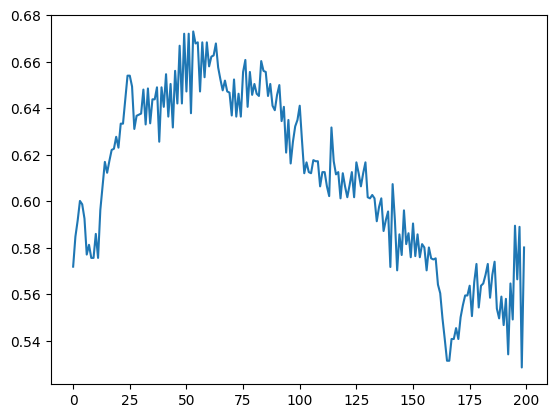

KeyboardInterrupt: 

In [12]:
d = len(train_dataset[0][0][0])
d2 = len(train_dataset[0][1][0])

tests = [
    # [4, 4, 4, 4],
    # [8, 8, 4, 4],
    # [4, 4, 8, 8],
    # [8, 8, 8, 8],
    [16, 16, 8, 8],
    # [8, 8, 16, 16],
    # [16, 16, 16, 16],
    # [32, 32, 8, 8],
    # [8, 8, 32, 32],
    # [32, 32, 32, 32],
]

for test in tests:
    print("===========================", test)
    torch.manual_seed(1)
    results = []
    for _ in range(5):
        model = DualSetRepClassifier(test[0], test[1], test[2], test[3], d, d2, 2)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        # optimizer = torch.optim.NAdam(model.parameters(), lr=0.0001)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.1)
        criterion = torch.nn.NLLLoss(weight=torch.FloatTensor(class_weights).to(device))
        
        trainer = MultisetTorchTrainer(
            model,
            optimizer,
            criterion,
            200,
            [BinaryAccuracy(), BinaryAUROC()],
            [BinaryAccuracy(), BinaryAUROC()],
            [BinaryAccuracy(), BinaryAUROC()],
            # scheduler=scheduler,
            monitor_metric=1,
            monitor_lower_is_better=False,
            silent=True
        )

        trainer.train(train_loader, valid_loader)
        r = trainer.test(test_loader)[0]
        print(r)
        plt.plot(trainer.monitored_values)
        plt.show()
        results.append(r["BinaryAUROC"])

    print("Mean", np.mean(results))
    print("Std", np.std(results))

### Deep Set

In [ ]:
d = 7

torch.manual_seed(1)

results = []
for _ in range(5):
    model = DeepSet(d, 1, 2, 32)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    criterion = torch.nn.NLLLoss()
    
    trainer = TorchTrainer(
        model,
        optimizer,
        criterion,
        300,
        [BinaryAccuracy(), BinaryAUROC()],
        [BinaryAccuracy(), BinaryAUROC()],
        [BinaryAccuracy(), BinaryAUROC()],
        scheduler=scheduler,
        # monitor_metric=1,
        # monitor_lower_is_better=False,
        silent=True
    )

    trainer.train(train_loader, valid_loader)
    r = trainer.test(test_loader)[0]
    print(r)
    results.append(r["BinaryAUROC"])

print("Mean", np.mean(results))
print("Std", np.std(results))

{'best_epoch': 25, 'loss': 0.8079639077186584, 'BinaryAccuracy': 0.5784313678741455, 'BinaryAUROC': 0.56585412852876}
{'best_epoch': 33, 'loss': 0.8391137719154358, 'BinaryAccuracy': 0.6078431606292725, 'BinaryAUROC': 0.5967819635803064}
{'best_epoch': 1, 'loss': 0.6950453519821167, 'BinaryAccuracy': 0.529411792755127, 'BinaryAUROC': 0.5094903169862222}
{'best_epoch': 78, 'loss': 0.7664653062820435, 'BinaryAccuracy': 0.5882353186607361, 'BinaryAUROC': 0.5751999229212834}
{'best_epoch': 6, 'loss': 0.7041472792625427, 'BinaryAccuracy': 0.5441176295280457, 'BinaryAUROC': 0.5254359764909914}
Mean 0.5545524617015127
Std 0.03229781031024666


## Regression

In [2]:
train, valid, test = molnet_loader("lipo", transformers=[])
enc = ECFPEncoder()

train_dataset = enc.encode(train.ids, [y[0] for y in train.y], label_dtype=torch.float)
valid_dataset = enc.encode(valid.ids, [y[0] for y in valid.y], label_dtype=torch.float)
test_dataset = enc.encode(test.ids, [y[0] for y in test.y], label_dtype=torch.float)

train_loader = DataLoader(train_dataset, batch_size=64)
valid_loader = DataLoader(valid_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

### Set Rep

=========================== [16, 16, 8, 8]
{'best_epoch': 71, 'loss': 1.083334173474993, 'R2Score': 0.102175772190094, 'RootMeanSquaredError': 1.0460377931594849}


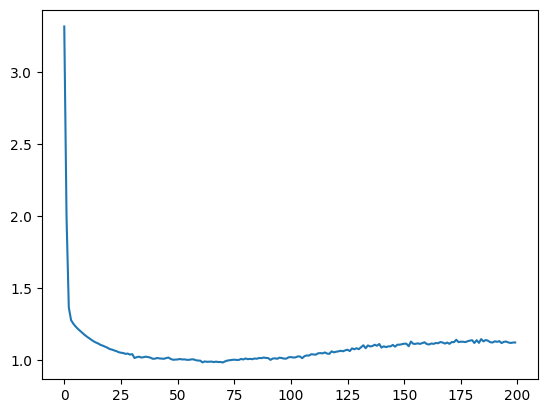

KeyboardInterrupt: 

In [11]:
d = len(train_dataset[0][0][0])
d2 = len(train_dataset[0][1][0])

tests = [
    # [4, 4, 4, 4],
    # [8, 8, 4, 4],
    # [4, 4, 8, 8],
    # [8, 8, 8, 8],
    [16, 16, 8, 8],
    # [8, 8, 16, 16],
    # [16, 16, 16, 16],
    # [32, 32, 8, 8],
    # [8, 8, 32, 32],
    # [32, 32, 32, 32],
]

for test in tests:
    print("===========================", test)
    torch.manual_seed(1)
    results = []
    for _ in range(5):
        model = DualSetRepRegressor(test[0], test[1], test[2], test[3], d, d2)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
        criterion = torch.nn.MSELoss()
        
        trainer = MultisetTorchTrainer(
            model,
            optimizer,
            criterion,
            200,
            [R2Score(), RootMeanSquaredError()],
            [R2Score(), RootMeanSquaredError()],
            [R2Score(), RootMeanSquaredError()],
            # scheduler=scheduler,
            # monitor_metric=1,
            # monitor_lower_is_better=False,
            silent=True
        )

        trainer.train(train_loader, valid_loader)
        r = trainer.test(test_loader)[0]
        print(r)
        plt.plot(trainer.monitored_values)
        plt.show()
        results.append(r["RootMeanSquaredError"])

    print("Mean", np.mean(results))
    print("Std", np.std(results))

# SECMQNFP

## Classification

In [ ]:
train, valid, test = molnet_loader("bbbp", splitter="scaffold")
enc = SECMQNFPEncoder()

train_dataset, valid_dataset, test_dataset = enc.encode(
    (train.ids, valid.ids, test.ids), 
    ([y[0] for y in train.y], [y[0] for y in valid.y], [y[0] for y in test.y]), 
    label_dtype=torch.long, standardize=False, radius=2, min_radius=0
)

train_loader = DataLoader(train_dataset, batch_size=128, sampler=ImbalancedSampler(train_dataset))
valid_loader = DataLoader(valid_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

### Set Rep Classifier

In [ ]:
d = 42

torch.manual_seed(1)

results = []
for _ in range(5):
    model = SetRepClassifier(1, 1, d, 2)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    criterion = torch.nn.NLLLoss()
    
    trainer = TorchTrainer(
        model,
        optimizer,
        criterion,
        200,
        [BinaryAccuracy(), BinaryAUROC()],
        [BinaryAccuracy(), BinaryAUROC()],
        [BinaryAccuracy(), BinaryAUROC()],
        # scheduler=scheduler,
        # monitor_metric=1,
        # monitor_lower_is_better=False,
        silent=True
    )

    trainer.train(train_loader, valid_loader)
    r = trainer.test(test_loader)[0]
    print(r)
    results.append(r["BinaryAUROC"])

print("Mean", np.mean(results))
print("Std", np.std(results))

# 100 epochs
# {'best_epoch': 90, 'loss': 0.8859325647354126, 'BinaryAccuracy': 0.6715686321258545, 'BinaryAUROC': 0.6671644667116292}
# {'best_epoch': 100, 'loss': 0.8769419193267822, 'BinaryAccuracy': 0.6911764740943909, 'BinaryAUROC': 0.6868195394546681}
# {'best_epoch': 85, 'loss': 0.8609354496002197, 'BinaryAccuracy': 0.6519607901573181, 'BinaryAUROC': 0.6446189420946141}
# {'best_epoch': 100, 'loss': 0.8549694418907166, 'BinaryAccuracy': 0.6323529481887817, 'BinaryAUROC': 0.6249638693515753}
# {'best_epoch': 98, 'loss': 0.7837579846382141, 'BinaryAccuracy': 0.6813725233078003, 'BinaryAUROC': 0.6755467771461605}
# Mean 0.6598227189517295
# Std 0.022254302099624954

# 200 epochs
# {'best_epoch': 197, 'loss': 0.9870814085006714, 'BinaryAccuracy': 0.6813725233078003, 'BinaryAUROC': 0.6760285191251566}
# {'best_epoch': 173, 'loss': 0.9504050612449646, 'BinaryAccuracy': 0.6274510025978088, 'BinaryAUROC': 0.6217361980923017}
# {'best_epoch': 93, 'loss': 0.9911300539970398, 'BinaryAccuracy': 0.6323529481887817, 'BinaryAUROC': 0.6283360632045476}
# {'best_epoch': 76, 'loss': 0.9773973226547241, 'BinaryAccuracy': 0.6813725233078003, 'BinaryAUROC': 0.6794007129781289}
# {'best_epoch': 188, 'loss': 0.8548866510391235, 'BinaryAccuracy': 0.686274528503418, 'BinaryAUROC': 0.6831101262163985}
# Mean 0.6577223239233068
# Std 0.026863221740548518

# 180 epochs (all the same as with 200) gives different results:
# {'best_epoch': 177, 'loss': 0.9327479600906372, 'BinaryAccuracy': 0.6617646813392639, 'BinaryAUROC': 0.6583004142981019}
# {'best_epoch': 176, 'loss': 0.8896770477294922, 'BinaryAccuracy': 0.6715686321258545, 'BinaryAUROC': 0.6652374987956451}
# {'best_epoch': 158, 'loss': 0.950018048286438, 'BinaryAccuracy': 0.6764705777168274, 'BinaryAUROC': 0.6699103959919067}
# {'best_epoch': 167, 'loss': 0.9776877164840698, 'BinaryAccuracy': 0.6715686321258545, 'BinaryAUROC': 0.6657192407746411}
# {'best_epoch': 117, 'loss': 0.9929808378219604, 'BinaryAccuracy': 0.656862735748291, 'BinaryAUROC': 0.6521822911648522}
# Mean 0.6622699682050295
# Std 0.0062705413182455715

{'best_epoch': 200, 'loss': 0.8124533891677856, 'BinaryAccuracy': 0.6127451062202454, 'BinaryAUROC': 0.6057905385875325}
{'best_epoch': 109, 'loss': 0.7147619724273682, 'BinaryAccuracy': 0.4852941036224365, 'BinaryAUROC': 0.4977839868966182}
{'best_epoch': 23, 'loss': 0.6919282674789429, 'BinaryAccuracy': 0.4803921580314636, 'BinaryAUROC': 0.5046728971962616}
{'best_epoch': 200, 'loss': 0.831345796585083, 'BinaryAccuracy': 0.6225489974021912, 'BinaryAUROC': 0.6117641391270835}
{'best_epoch': 188, 'loss': 0.8055750131607056, 'BinaryAccuracy': 0.6225489974021912, 'BinaryAUROC': 0.6117641391270835}
Mean 0.5663551401869159
Std 0.0532650113684983


### Deep Set Classifier

In [ ]:
d = 42

torch.manual_seed(1)

results = []
for _ in range(5):
    # model = SetRepClassifier(1, 1, d, 2)
    model = DeepSet(d, 1, 2, 64)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    criterion = torch.nn.NLLLoss()
    
    trainer = TorchTrainer(
        model,
        optimizer,
        criterion,
        200,
        [BinaryAccuracy(), BinaryAUROC()],
        [BinaryAccuracy(), BinaryAUROC()],
        [BinaryAccuracy(), BinaryAUROC()],
        # scheduler=scheduler,
        monitor_metric=1,
        monitor_lower_is_better=False,
        silent=True
    )

    trainer.train(train_loader, valid_loader)
    r = trainer.test(test_loader)[0]
    print(r)
    results.append(r["BinaryAUROC"])

print("Mean", np.mean(results))
print("Std", np.std(results))

{'best_epoch': 112, 'loss': 0.9314103722572327, 'BinaryAccuracy': 0.6323529481887817, 'BinaryAUROC': 0.6235186434145872}
{'best_epoch': 112, 'loss': 0.9856001138687134, 'BinaryAccuracy': 0.6127451062202454, 'BinaryAUROC': 0.6000096348395799}
{'best_epoch': 150, 'loss': 0.9422915577888489, 'BinaryAccuracy': 0.6666666865348816, 'BinaryAUROC': 0.6586376336833992}
{'best_epoch': 23, 'loss': 0.8390119671821594, 'BinaryAccuracy': 0.6323529481887817, 'BinaryAUROC': 0.6312265150785239}
{'best_epoch': 172, 'loss': 0.8673347234725952, 'BinaryAccuracy': 0.6127451062202454, 'BinaryAUROC': 0.6053087966085364}
Mean 0.6237402447249254
Std 0.02086519222180576


## Regression

In [ ]:
train, valid, test = molnet_loader("lipo")
enc = SECMQNFPEncoder()

train_dataset, valid_dataset, test_dataset = enc.encode(
    (train.ids, valid.ids, test.ids), 
    ([y[0] for y in train.y], [y[0] for y in valid.y], [y[0] for y in test.y]), 
    label_dtype=torch.float, standardize=False
)

train_loader = DataLoader(train_dataset, batch_size=64)
valid_loader = DataLoader(valid_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
d = 42
model = SetRepRegressor(8, 32, d)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = torch.nn.MSELoss()

trainer = TorchTrainer(
    model,
    optimizer,
    criterion,
    200,
    [R2Score(), RootMeanSquaredError()],
    [R2Score(), RootMeanSquaredError()],
    [R2Score(), RootMeanSquaredError()],
    scheduler=scheduler,
    monitor_metric=1,
    monitor_lower_is_better=True
)

trainer.train(train_loader, valid_loader)
trainer.test(test_loader)

# SECFP

## Classification

In [ ]:
train, valid, test = molnet_loader("bace_classification")
graph_embedder = SECFPEncoder.fit(train.ids)

enc = SECFPEncoder()

train_dataset = enc.encode(train.ids, [y[0] for y in train.y], label_dtype=torch.long, graph_embedder=graph_embedder, pretrained_graph_embedder=True)
valid_dataset = enc.encode(valid.ids, [y[0] for y in valid.y], label_dtype=torch.long, graph_embedder=graph_embedder, pretrained_graph_embedder=True)
test_dataset = enc.encode(test.ids, [y[0] for y in test.y], label_dtype=torch.long, graph_embedder=graph_embedder, pretrained_graph_embedder=True)

train_loader = DataLoader(train_dataset, batch_size=64, sampler=ImbalancedSampler(train_dataset))
valid_loader = DataLoader(valid_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
d = 500
model = SetRepClassifier(2, 8, d, 2)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
criterion = torch.nn.NLLLoss()

trainer = TorchTrainer(
    model,
    optimizer,
    criterion,
    60,
    [BinaryAccuracy(), BinaryAUROC()],
    [BinaryAccuracy(), BinaryAUROC()],
    [BinaryAccuracy(), BinaryAUROC()],
    # scheduler=scheduler,
    monitor_metric=1,
    monitor_lower_is_better=False
)

trainer.train(train_loader, valid_loader)
trainer.test(test_loader)

## Regression

# Mol2Vec

## Classification

In [ ]:
train, valid, test = molnet_loader("bbbp")
enc = Mol2SetEncoder()

train_dataset = enc.encode(train.ids, [y[0] for y in train.y], label_dtype=torch.long)
valid_dataset = enc.encode(valid.ids, [y[0] for y in valid.y], label_dtype=torch.long)
test_dataset = enc.encode(test.ids, [y[0] for y in test.y], label_dtype=torch.long)

train_loader = DataLoader(train_dataset, batch_size=128, sampler=ImbalancedSampler(train_dataset))
valid_loader = DataLoader(valid_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

In [ ]:
d = 300
model = SetRepClassifier(8, 16, d, 2)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
criterion = torch.nn.NLLLoss()

trainer = TorchTrainer(
    model,
    optimizer,
    criterion,
    60,
    [BinaryAccuracy(), BinaryAUROC()],
    [BinaryAccuracy(), BinaryAUROC()],
    [BinaryAccuracy(), BinaryAUROC()],
    # scheduler=scheduler,
    monitor_metric=1,
    monitor_lower_is_better=False
)

trainer.train(train_loader, valid_loader)
trainer.test(test_loader)

## Regression

In [ ]:
train, valid, test = molnet_loader("delaney", splitter="random")
enc = Mol2SetEncoder()

train_dataset = enc.encode(train.ids, [y[0] for y in train.y], label_dtype=torch.float)
valid_dataset = enc.encode(valid.ids, [y[0] for y in valid.y], label_dtype=torch.float)
test_dataset = enc.encode(test.ids, [y[0] for y in test.y], label_dtype=torch.float)

train_loader = DataLoader(train_dataset, batch_size=64)
valid_loader = DataLoader(valid_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
d = 300
model = SetRepRegressor(100, 16, d)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = torch.nn.MSELoss()

trainer = TorchTrainer(
    model,
    optimizer,
    criterion,
    200,
    [R2Score(), MeanSquaredError(squared=False), MeanAbsoluteError()],
    [R2Score(), MeanSquaredError(squared=False), MeanAbsoluteError()],
    [R2Score(), MeanSquaredError(squared=False), MeanAbsoluteError()],
    scheduler=scheduler,
    monitor_metric=1,
    monitor_lower_is_better=True
)

trainer.train(train_loader, valid_loader)
trainer.test(test_loader)